In [56]:
from calendar import month_name
from contextlib import contextmanager
from glob import glob
import inspect
from itertools import product
import os
import re
from sre_constants import CATEGORY_SPACE
import sys
from pathlib import Path
from time import time
from typing import Iterable, Optional, Union

import category_encoders as ce
import lightgbm as lgbm
from IPython.display import display
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, StratifiedGroupKFold, GroupKFold, RepeatedKFold
import sweetviz as sv
from tqdm import tqdm

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)

# CFG

In [2]:
class CFG:
    """ Config

        input folder , output folderを作成し、
        提出用csvに名前をつけてouput folderに格納

    """

    n_fold = 5
    n_repeated_fold = 3
    seed = 42
    TARGET = '取引価格（総額）_log'
    exp_folder_name = "exp001/"
    exp_name = "exp001"
    INPUT_DIR = Path("../input")
    OUTPUT_DIR = Path("../output/0_chanzon-khm/")
    EXP_DIR = os.path.join(OUTPUT_DIR, exp_folder_name)
    

os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)
os.makedirs(CFG.EXP_DIR, exist_ok=True)

# Utils

In [3]:
class Timer:
    def __init__(
        self,
        logger=None,
        format_str="{:.3f}[s]",
        prefix=None,
        suffix=None,
        sep=" ",
        verbose=0,
    ):

        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):  # withステートメントが実行されたときに initの次に実行される
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):  # withステートメントの実行が終わるときに最後に実行される
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = "★" * 20

    return " ".join([decoration, str(s), decoration])


def param_to_name(params: dict, key_sep="_", key_value_sep="=") -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = "__cachefile__"

    def wrapper(*args, **kwrgs):
        force = kwrgs.pop("force", False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print("run")
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper


@cachable
def read_csv(name):

    if ".csv" not in name:
        name = name + ".csv"

    return pd.read_csv(os.path.join(CFG.INPUT_DIR, name))

@cachable
def read_pkl(name):

    if ".pkl" not in name:
        name = name + ".pkl"

    return pd.read_pickle(os.path.join(CFG.INPUT_DIR, name))

# read data

In [4]:
paths = glob(os.path.join(CFG.INPUT_DIR,'train/*'))
train_dfs = []
for path in paths:
    _df = pd.read_csv(path)
    train_dfs.append(_df)
del _df
train_all_df = pd.concat(train_dfs)
train_all_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'test.csv'))

/tmp/ipykernel_8667/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_8667/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_8667/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_8667/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)


# EDA

In [5]:
train_all_df.shape, test_df.shape

((779404, 28), (18394, 27))

In [6]:
train_all_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

## 数値データ列に混在する文字列の前処理

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [8]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [9]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [10]:
train_all_df['建築年'] = train_all_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
test_df['建築年'] = test_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
train_all_df['面積（㎡）'] = train_all_df['面積（㎡）'].apply(lambda x: normalize_area(x))
test_df['面積（㎡）'] = test_df['面積（㎡）'].apply(lambda x: normalize_area(x))
train_all_df['最寄駅：距離（分）'] = train_all_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
test_df['最寄駅：距離（分）'] = test_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

enc_dic = {}
all_df = pd.concat([train_all_df, test_df])

for i, e in enumerate(sorted(list(set(all_df['取引時点'].values)))):
    enc_dic[e] = i
all_df['取引時点_enc'] = all_df['取引時点'].map(enc_dic)


# 欠損列を削除
rm_cols = []
for i,v in all_df.nunique().items():
    if v <= 1:
        rm_cols.append(i)

all_df.drop(rm_cols, axis=1, inplace=True)
        

all_df[all_df['取引価格（総額）_log'].notnull()].copy().to_csv('train_all.csv', index=False, header=True)
all_df[all_df['取引価格（総額）_log'].isnull()].copy().to_csv('test.csv', index=False, header=True)



## sweetviz

In [11]:
# import sweetviz as sv
# sv.config_parser.read("../sweetviz_settings/sweetviz_settings.ini") # 1回目の実行だとなぜか日本語文字化けする・・?

In [12]:
# import sweetviz as sv
# my_report = sv.compare([train_all_df, 'train'], [test_df, "test"], CFG.TARGET)
# sv.config_parser.read("../sweetviz_settings/sweetviz_settings.ini")
# my_report.show_html("sweetviz_report2.html")

## データの確認

In [13]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797798 entries, 0 to 18393
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            797798 non-null  int64  
 1   市区町村コード       797798 non-null  int64  
 2   都道府県名         797798 non-null  object 
 3   市区町村名         797798 non-null  object 
 4   地区名           797123 non-null  object 
 5   最寄駅：名称        794997 non-null  object 
 6   最寄駅：距離（分）     774571 non-null  float64
 7   間取り           767447 non-null  object 
 8   面積（㎡）         797798 non-null  int64  
 9   建築年           774523 non-null  float64
 10  建物の構造         774589 non-null  object 
 11  用途            707489 non-null  object 
 12  今後の利用目的       428917 non-null  object 
 13  都市計画          776902 non-null  object 
 14  建ぺい率（％）       772172 non-null  float64
 15  容積率（％）        772172 non-null  float64
 16  取引時点          797798 non-null  object 
 17  改装            718365 non-null  object 
 18  取引の事情等    

# 前処理


In [14]:

@cachable
def read_train_all_df():
    return pd.read_csv('train_all.csv')

@cachable
def read_test_df():
    return pd.read_csv('test.csv')


@cachable
def read_whole_df():
    whole_df = pd.concat([read_train_all_df(),read_test_df()], ignore_index=True)
    return whole_df.sort_values('取引時点').reset_index(drop=True)

train_all_df = read_train_all_df()
test_df = read_test_df()
whole_df = read_whole_df()

# 後で、train,valid分割ように、取引時点の時系列に並び替えたい
train_all_df = whole_df[whole_df['取引価格（総額）_log'].notnull()].copy()
test_df = whole_df[whole_df['取引価格（総額）_log'].isnull()].copy()

run


run
run


## AbstractBaseBlock

In [15]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [16]:
class NumericBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = [column]

    def transform(self, input_df):
        return input_df[self.column].copy()

In [17]:
# 表記ゆれの処理

# class NormalizeMoyori(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
    
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.normalize_moyori(x))

#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def normalize_moyori(moyori):
#         if moyori == moyori:
#             if moyori == '30分?60分':
#                 moyori = 45
#             elif moyori == '1H?1H30':
#                 moyori = 75
#             elif moyori == '1H30?2H':
#                 moyori = 105
#             elif moyori == '2H?':
#                 moyori = 120
                                
#             moyori = int(float(moyori))
        
#         return moyori
    

# class NormalizeArea(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
        
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.normalize_area(x))
        
#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def normalize_area(area):
#         if area == area:
#             area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
#         return area


# class CovertWarekiToSeireki(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
        
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.convert_wareki_to_seireki(x))
#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def convert_wareki_to_seireki(wareki):
#         if wareki == wareki:
#             if wareki == '戦前':
#                 wareki = '昭和20年'
#             value = wareki[2:-1]
#             if value == '元':
#                 value = 1
#             else:
#                 value = int(value)
#             if '昭和' in wareki:
#                 seireki = 1925+value
#             elif '平成' in wareki:
#                 seireki = 1988+value
#             elif '令和' in wareki:
#                 seireki = 2018+value
#         else:
#             seireki = wareki
#         return seireki

In [18]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count

    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories

        return self.transform(input_df)

    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat, drop_first=True)
        out_df.columns = out_df.columns.tolist()
        out_df.index = input_df.index.tolist() # indexが飛び飛びのデータの場合、このブロックではindex振り直しになるため、run_blocksのconcatでおかしくなるため
        return out_df.add_prefix(f"{self.column}=")

In [115]:
class LabelEncoding(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
        self.encoder = LabelEncoder()

    def fit(self, input_df, y=None):
        self.encoder.fit(input_df[self.column])
        
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = input_df[[self.column]].copy()

        
        # 既知のラベルのリストを取得
        known_labels = self.encoder.classes_

        # 未知のラベルを持つ行を特定
        unknown_mask = ~out_df[self.column].isin(known_labels)
        # 未知のラベルを持つ行に-999を設定
        out_df.loc[unknown_mask, self.column] = -999

        # 未知のラベルの行以外のエントリにtransformを適用
        known_mask = ~unknown_mask & out_df[self.column].notnull()
        out_df.loc[known_mask, self.column] = \
            self.encoder.transform(out_df[known_mask][self.column])

        out_df.fillna(-99, inplace=True)
        out_df[self.column] = out_df[self.column].astype('int64')
        return out_df.add_prefix(f"LE_")


In [116]:
class MeanOfCol_ruikei(AbstractBaseBlock):
    def __init__(self, group_col):
        self.te_dic = {}
        self.time_col = '取引時点_enc'
        self.group_col = group_col
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        whole_df = read_whole_df()
        
        for i in set(whole_df[self.time_col].values):
            tmp_df = whole_df[whole_df[self.time_col] < i]
            self.te_dic[i] = tmp_df.groupby(self.group_col)[CFG.TARGET].agg('mean').to_dict()
            
        out_df[self.group_col] = input_df.apply(self.calc_te, axis=1)

        return out_df
    
    def calc_te(self, row):
        if row[self.time_col] in self.te_dic and row[self.group_col] in self.te_dic[row[self.time_col]]:
            return self.te_dic[row[self.time_col]][row[self.group_col]]
        else:
            return np.nan


In [117]:
class BeforeYearTraded(AbstractBaseBlock):
    def __init__(self, year):
        self.year = year
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[f'{self.year}-取引時点'] = input_df['取引時点'].apply(lambda x: self.year-int(x[:4]))
        return out_df
        

In [134]:
class GetCombi(AbstractBaseBlock):
    def __init__(self, columns:list):
        """
        特徴量を2つ指定 掛け算
        """
        self.columns = columns
        
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        if "％" in self.columns[0]:
            col1 = (input_df[self.columns[0]] / 100).copy()
        else:
            col1 = input_df[self.columns[0]].copy()
        if "％" in self.columns[1]:
            col2 = (input_df[self.columns[1]] / 100).copy()
        else:
            col2 = input_df[self.columns[1]].copy()
            
        new_col_name = f'combi_{self.columns[0]} * {self.columns[1]}'
        
        out_df[new_col_name] = col1 * col2
        return out_df
    

In [135]:
# 本来なら、trainデータで集計した値をtestに当てはめるべき
class GetAggDf(AbstractBaseBlock):
    def __init__(self, group_col):
        self.group_col = group_col
    
    
    def transform(self, input_df):
        agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
        out_df = pd.DataFrame()
        whole_df = read_whole_df()
        functions = ["count", "mean", "min", "max"]
        for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
            col_name = f"{col}_{function}"
            out_df[col_name] = whole_df.groupby(self.group_col)[col].transform(function) # transform()を使うと、groupbyで集計したデータを元データに結合できる
    
        if len(input_df) > 20000:
            tr_idx = whole_df[whole_df[CFG.TARGET].notnull()].index
            return out_df.loc[tr_idx, :]
        
        else:
            ts_idx = whole_df[whole_df[CFG.TARGET].isnull()].index
            return out_df.loc[ts_idx, :]


# run blocks

In [136]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)

    return out_df

In [137]:
num_cols = train_all_df.select_dtypes('number')
num_cols.drop([CFG.TARGET, 'ID'], axis=1, inplace=True)

cat_cols = train_all_df.select_dtypes('object')

group_cols = ['都道府県名']
before_year_trade_list = [2021]

get_combi_cols = [["面積（㎡）", "容積率（％）"]]

In [138]:
feature_blocks = [
    *[NumericBlock(c) for c in num_cols],
    *[LabelEncoding(c) for c in cat_cols],
    *[MeanOfCol_ruikei(c) for c in group_cols],
    *[BeforeYearTraded(c) for c in before_year_trade_list],
    *[GetCombi(c) for c in get_combi_cols],
    *[GetAggDf(c) for c in group_cols],
    
]


In [139]:
train_feat_df = run_blocks(input_df = train_all_df, blocks=feature_blocks, y=None, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.NumericBlock object at 0x7f079dec8650> 0.003[s]
	- <__main__.NumericBlock object at 0x7f078f76fcd0> 0.005[s]
	- <__main__.NumericBlock object at 0x7f07833a1110> 0.003[s]
	- <__main__.NumericBlock object at 0x7f0782019750> 0.003[s]
	- <__main__.NumericBlock object at 0x7f078f769010> 0.002[s]
	- <__main__.NumericBlock object at 0x7f078f76b2d0> 0.003[s]
	- <__main__.NumericBlock object at 0x7f078f76bc50> 0.004[s]
	- <__main__.LabelEncoding object at 0x7f078f769b90> 0.369[s]
	- <__main__.LabelEncoding object at 0x7f078f768790> 0.539[s]
	- <__main__.LabelEncoding object at 0x7f078200c810> 0.693[s]
	- <__main__.LabelEncoding object at 0x7f078200c510> 0.408[s]
	- <__main__.LabelEncoding object at 0x7f078200c2d0> 0.272[s]
	- <__main__.LabelEncoding object at 0x7f0794e7c7d0> 0.255[s]
	- <__main__.LabelEncoding object at 0x7f0794e7f1d0> 0.289[s]
	- <__main__.LabelEncoding object at 0x7f0794e7ee10> 0.269[s]
	- <__main__.La

In [140]:
train_feat_df

,市区町村コード@NumericBlock,最寄駅：距離（分）@NumericBlock,面積（㎡）@NumericBlock,建築年@NumericBlock,建ぺい率（％）@NumericBlock,容積率（％）@NumericBlock,取引時点_enc@NumericBlock,LE_都道府県名@LabelEncoding,LE_市区町村名@LabelEncoding,LE_地区名@LabelEncoding,LE_最寄駅：名称@LabelEncoding,LE_間取り@LabelEncoding,LE_建物の構造@LabelEncoding,LE_用途@LabelEncoding,LE_今後の利用目的@LabelEncoding,LE_都市計画@LabelEncoding,LE_取引時点@LabelEncoding,LE_改装@LabelEncoding,LE_取引の事情等@LabelEncoding,都道府県名@MeanOfCol_ruikei,2021-取引時点@BeforeYearTraded,combi_面積（㎡） * 容積率（％）@GetCombi,最寄駅：距離（分）_count@GetAggDf,最寄駅：距離（分）_mean@GetAggDf,最寄駅：距離（分）_min@GetAggDf,最寄駅：距離（分）_max@GetAggDf,面積（㎡）_count@GetAggDf,面積（㎡）_mean@GetAggDf,面積（㎡）_min@GetAggDf,面積（㎡）_max@GetAggDf,建ぺい率（％）_count@GetAggDf,建ぺい率（％）_mean@GetAggDf,建ぺい率（％）_min@GetAggDf,建ぺい率（％）_max@GetAggDf,容積率（％）_count@GetAggDf,容積率（％）_mean@GetAggDf,容積率（％）_min@GetAggDf,容積率（％）_max@GetAggDf
0,13114,NaN,40,2005.0,60.0,150.0,0,26,40,621,3175,19,4,6,-99,9,0,-99,-99,NaN,16,60.0,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
1,13104,NaN,55,2005.0,60.0,300.0,0,26,322,11924,3777,27,-99,6,-99,8,0,1,-99,NaN,16,165.0,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
2,23107,8.0,70,1995.0,80.0,300.0,0,24,149,5622,1720,39,4,6,-99,14,0,0,-99,NaN,16,210.0,37452,12.731790,0.0,120.0,38198,68.011807,10,790,37541,66.164194,30.0,80.0,37541,276.277670,50.0,1000.0
3,13119,16.0,50,1969.0,60.0,200.0,0,26,370,9911,192,33,4,6,-99,8,0,1,-99,NaN,16,100.0,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
4,14135,6.0,45,1967.0,NaN,NaN,0,32,280,322,2724,19,4,6,-99,-99,0,1,4,NaN,16,NaN,108822,13.497978,0.0,120.0,112773,58.445639,10,1100,106612,65.441039,30.0,80.0,106612,257.477301,50.0,1200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779399,13103,11.0,70,2015.0,60.0,400.0,67,26,440,9803,2742,39,4,6,2,6,67,1,-99,7.409042,-1,280.0,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
779400,12103,19.0,80,1984.0,60.0,200.0,67,5,119,4811,2932,39,8,-99,2,10,67,0,-99,7.170546,-1,160.0,40536,13.473752,0.0,120.0,41171,68.690462,10,880,39273,62.814402,30.0,80.0,39273,226.051740,60.0,900.0
779401,27224,13.0,70,1982.0,60.0,200.0,67,9,320,2517,835,-99,8,6,2,11,67,-99,-99,7.191502,-1,140.0,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0
779402,27123,13.0,55,1988.0,80.0,300.0,67,9,214,6548,3240,27,8,6,2,10,67,1,-99,7.191502,-1,165.0,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0


# model

In [141]:
def fit_lgbm_regressor(
    X: np.ndarray,
    y: np.ndarray,
    cv: Iterable,
    y_max: Optional[float] = None,
    params: Optional[dict] = None,
    callbacks: Optional[list] = None,
    verbose: Optional[int] = 50,
    n_repeats = None
):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None  # yの上限が有る場合は上限値を指定し上限以上の値は丸め込み
    
    if n_repeats is not None:
        n_splits = len(cv) / n_repeats
        
    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=float)
    oof_preds = []
    rmse_scores = []
    r2_scores = []
    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        model = lgbm.LGBMRegressor(**params)
        
        print(decorate(f"fit fold = {i}"))
        with Timer(prefix="fit fold={} ".format(i), verbose=verbose):
            model.fit(
                x_train,
                y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks = callbacks
            )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i # ToDo Repeated KFOLDのときは、最後のK-FOLDのデータがoofと
        models.append(model)
        
        # foldごとに結果を出力
        if not is_silent:
            print(f"Fold {i} train RMSE: {np.sqrt(mean_squared_error(y_train, model.predict(x_train)))}") 
            print(f"Fold {i} valid RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i))}") 
            print(f"Fold {i} train R2-score: {r2_score(y_train, model.predict(x_train))}") 
            print(f"Fold {i} valid R2-score: {r2_score(y_valid, pred_i)}") 


        # RepeatedKFold のリピート毎にデータごとに結果を取得&出力
        if n_repeats is not None:
            if (i + 1) % n_splits == 0:
                oof_preds.append(oof_pred)
                rmse = np.sqrt(mean_squared_error(y, oof_pred))
                r2 = r2_score(y, oof_pred)
                print(decorate(f"Repeated No = {n_repeats} is fin"))
                print('Whole valid RMSE: {:.4f}'.format(rmse))
                print('Whole valid r2_score: {:.4f}'.format(r2))
                print('----------------------------------------')
                # リピートが終わったら初期化 ※初期化しない場合はデータが上書きされるので、oof_predsは値を参照しているので、最初にappendしたデータも更新されてしまう
                oof_pred = np.zeros_like(y, dtype=float)
    
    # 全体のスコアを返す。 RepeatedKFoldのときは、RepeatごとのWholeスコアの平均
    if not is_silent:
        if n_repeats is None:
            rmse = np.sqrt(mean_squared_error(y, oof_pred))
            r2 = r2_score(y, oof_pred)
            print('Whole valid RMSE: {:.4f}'.format(rmse))
            print('Whole valid r2_score: {:.4f}'.format(r2))

        else:
            mean_oof_preds = np.mean(oof_preds, axis=0)
            rmse = np.sqrt(mean_squared_error(y, mean_oof_preds))
            r2 = r2_score(y, mean_oof_preds)
            print('Repeated Whole valid RMSE: {:.4f}'.format(rmse))
            print('Repeated Whole valid r2_score: {:.4f}'.format(r2))
    if n_repeats is None:
        return oof_pred, models
    else:
        return oof_preds, models

# 学習実行

In [142]:
val_min_idx = min(whole_df[whole_df['取引時点'].str.contains('2022年第1四半期|2022年第2四半期', regex=True)].index) # 該当の取引時点のindexを引っ張ってくる
test_min_idx = min(whole_df[whole_df['取引時点'].str.contains('2022年第3四半期|2022年第4四半期', regex=True)].index)
val_min_idx, test_min_idx

(751910, 779404)

In [143]:
train_x = train_feat_df.iloc[:val_min_idx, :]
train_y = train_all_df.iloc[:val_min_idx][CFG.TARGET]
val_x = train_feat_df.iloc[val_min_idx:test_min_idx, :]
val_y = train_all_df.iloc[val_min_idx:test_min_idx][CFG.TARGET]
print(train_x.shape, val_x.shape)

(751910, 38) (27494, 38)


In [149]:
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}
verbose_eval = 100
early_stopping_rounds = 100

model = lgbm.LGBMRegressor(**params)


callbacks = [
    lgbm.early_stopping(stopping_rounds=early_stopping_rounds),
    lgbm.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
    lgbm.log_evaluation(verbose_eval),
]

model.fit(
    train_x,
    train_y,
    eval_set=[(val_x, val_y)],
    callbacks = callbacks,
)

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.104145
[200]	valid_0's l1: 0.0949399
[300]	valid_0's l1: 0.0911884
[400]	valid_0's l1: 0.0889842
[500]	valid_0's l1: 0.0874438
[600]	valid_0's l1: 0.0862888
[700]	valid_0's l1: 0.0852731
[800]	valid_0's l1: 0.0845457
[900]	valid_0's l1: 0.0838947
[1000]	valid_0's l1: 0.0832913
[1100]	valid_0's l1: 0.0829385
[1200]	valid_0's l1: 0.0824854
[1300]	valid_0's l1: 0.0820743
[1400]	valid_0's l1: 0.0817131
[1500]	valid_0's l1: 0.0813673
[1600]	valid_0's l1: 0.0810967
[1700]	valid_0's l1: 0.080786
[1800]	valid_0's l1: 0.080531
[1900]	valid_0's l1: 0.0802664
[2000]	valid_0's l1: 0.0800762
[2100]	valid_0's l1: 0.0798512
[2200]	valid_0's l1: 0.0796963
[2300]	valid_0's l1: 0.0795496
[2400]	valid_0's l1: 0.0794122
[2500]	valid_0's l1: 0.0793308
[2600]	valid_0's l1: 0.0792592
[2700]	valid_0's l1: 0.0791224
[2800]	valid_0's l1: 0.0790043
[2900]	valid_0's l1:

LGBMRegressor(bagging_fraction=0.95, boosting='gbdt', early_stopping_rounds=100,
              feature_fraction=0.8, lambda_l1=0.1, lambda_l2=10, max_depth=7,
              metric='mae', min_data_in_leaf=2, num_boost_round=50000,
              num_leaves=42, objective='regression', random_state=42,
              subsample_freq=1, verbosity=-1)

In [154]:
val_pred = model.predict(val_x, num_iteration=model.best_iteration_)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

score: 0.0773


# test推論

In [ ]:
test_feat_df = run_blocks(input_df = test_df, blocks=feature_blocks, y=None, test=True)

In [157]:
test_pred = model.predict(test_feat_df, num_iteration=model.best_iteration_)


In [158]:
test_df[CFG.TARGET] = test_pred

In [ ]:
sub_df = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'sample_submission.csv'))
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', CFG.TARGET]], on='ID')
sub_df.to_csv(CFG.exp_name, os.path.join(CFG.OUTPUT_DIR, '0_chanzone-khm', CFG.exp_folder_name))

In [170]:
sub_df.to_csv(f'{CFG.exp_name}.csv')

In [ ]:
aaaaaaaaaaaaaaaaaaaaaaaaaa

In [145]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgbm.Dataset(train_x, label=train_y)
val_data = lgbm.Dataset(val_x, label=val_y)

verbose_eval = 100 # この数字を1にすると学習時のスコア推移がコマンドライン表示される
early_stopping_rounds = 100

model = lgbm.train(
    params,
    train_data,
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data],
    callbacks = [lgbm.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
                lgbm.log_evaluation(verbose_eval)],
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# 一旦パラメータは特にいじらず、精度を見てみる
n_estimators = 1500
lr = 0.05
max_depth = 1
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します.
    "objective" : "regression",
    "metric" : "rmse",
    "n_estimators" : n_estimators, # default 100
    "learning_rate" : lr, # default 0.1
    "boosting_type" : 'gbdt', # default gbdt
    "max_depth" : max_depth, # default -1 上限なし
    "importance_type" : 'gain',
    "seed" : 0
}

callbacks = [
    lgbm.early_stopping(stopping_rounds=10),
]

train_df.reset_index(drop=True, inplace=True)
y_train = train_df[y_col].values

# cv = group_repeated_kfold_split(train_df, col_group='waveform_no', n_splits=CFG.n_fold, n_repeats=CFG.n_repeated_kfold, random_state=CFG.seed,)
cv = group_repeated_kfold_split(train_df, col_group='waveform_no', n_splits=5, n_repeats=2, random_state=CFG.seed,)

# cv = group_kfold_split(train_df, col_group=col_group, n_splits=CFG.n_fold, random_state=CFG.seed,)
# fold = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# cv = list(fold.split(train_feat_df, y_train)) # もともとが generator なため明示的に list に変換する

print(decorate("start training"))

oofs, models= fit_lgbm_regressor(
    train_feat_df.values,
    y_train,
    cv=cv,
    params=params,
    callbacks=callbacks,
    verbose=500,
    n_repeats=2
)
print(decorate("FINISHED"))

print()
models_best_iterations = [model.best_iteration_ for model in models]
print(f'max iteration is {np.max(models_best_iterations)}')
print(f'min iteration is {np.min(models_best_iterations)}')
print(f'median iteration is {np.median(models_best_iterations)}')



★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ fit fold = 0 ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1052]	valid_0's rmse: 0.373591
fit fold=0  6.859[s]
Fold 0 train RMSE: 0.15582281026819356
Fold 0 valid RMSE: 0.3735909051143479
Fold 0 train R2-score: 0.9971296321379182
Fold 0 valid R2-score: 0.9827405789455071
★★★★★★★★★★★★★★★★★★★★ fit fold = 1 ★★★★★★★★★★★★★★★★★★★★
Early stopping, best iteration is:
[884]	valid_0's rmse: 0.340831
fit fold=1  5.683[s]
Fold 1 train RMSE: 0.16990597973294222
Fold 1 valid RMSE: 0.3408305127706793
Fold 1 train R2-score: 0.9964665216659783
Fold 1 valid R2-score: 0.9874385953172449
★★★★★★★★★★★★★★★★★★★★ fit fold = 2 ★★★★★★★★★★★★★★★★★★★★
Early stopping, best iteration is:
[653]	valid_0's rmse: 0.338761
fit fold=2  5.822[s]
Fold 2 train RMSE: 0.1982002964954818
Fold 2 valid RMSE: 0.33876120775873947
Fold 2 train R2-score: 0.9954267978003762
Fold 2 valid R

<AxesSubplot:>

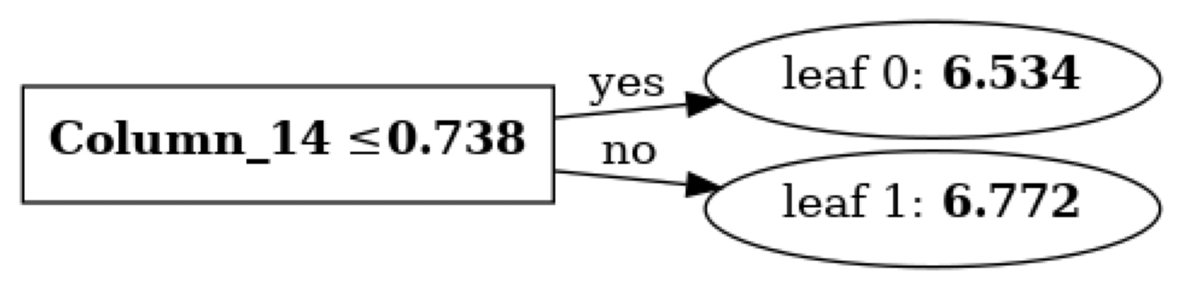

In [ ]:
lgbm.plot_tree(models[0],  figsize=(15,20))

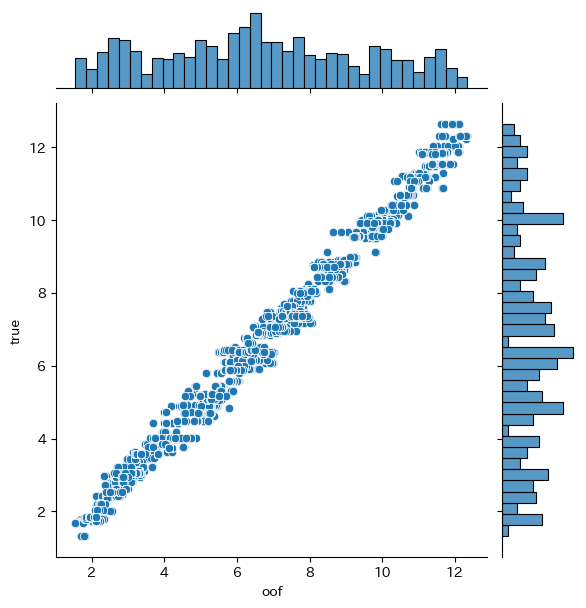

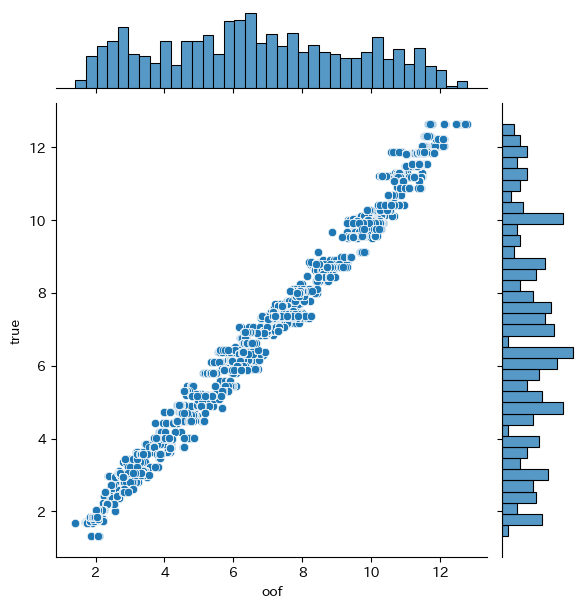

In [ ]:
for i in range(len(oofs)):
    sns.jointplot(x=oofs[i], y=train_df[y_col])
    r2_score(train_df[y_col], oofs[i])
    plt.xlabel('oof')
    plt.ylabel('true')
    plt.show()



<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

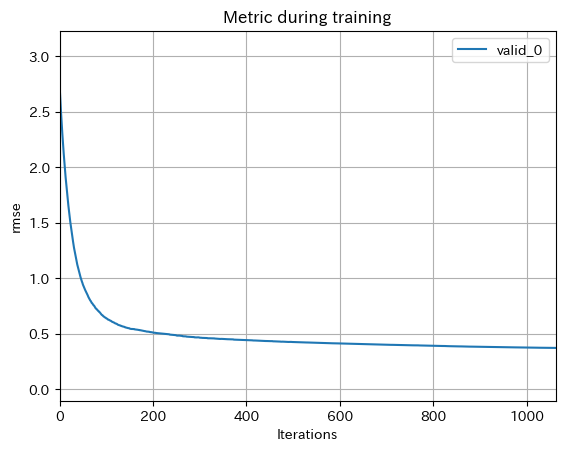

In [ ]:
# 
lgbm.plot_metric(models[0])

# feature importance

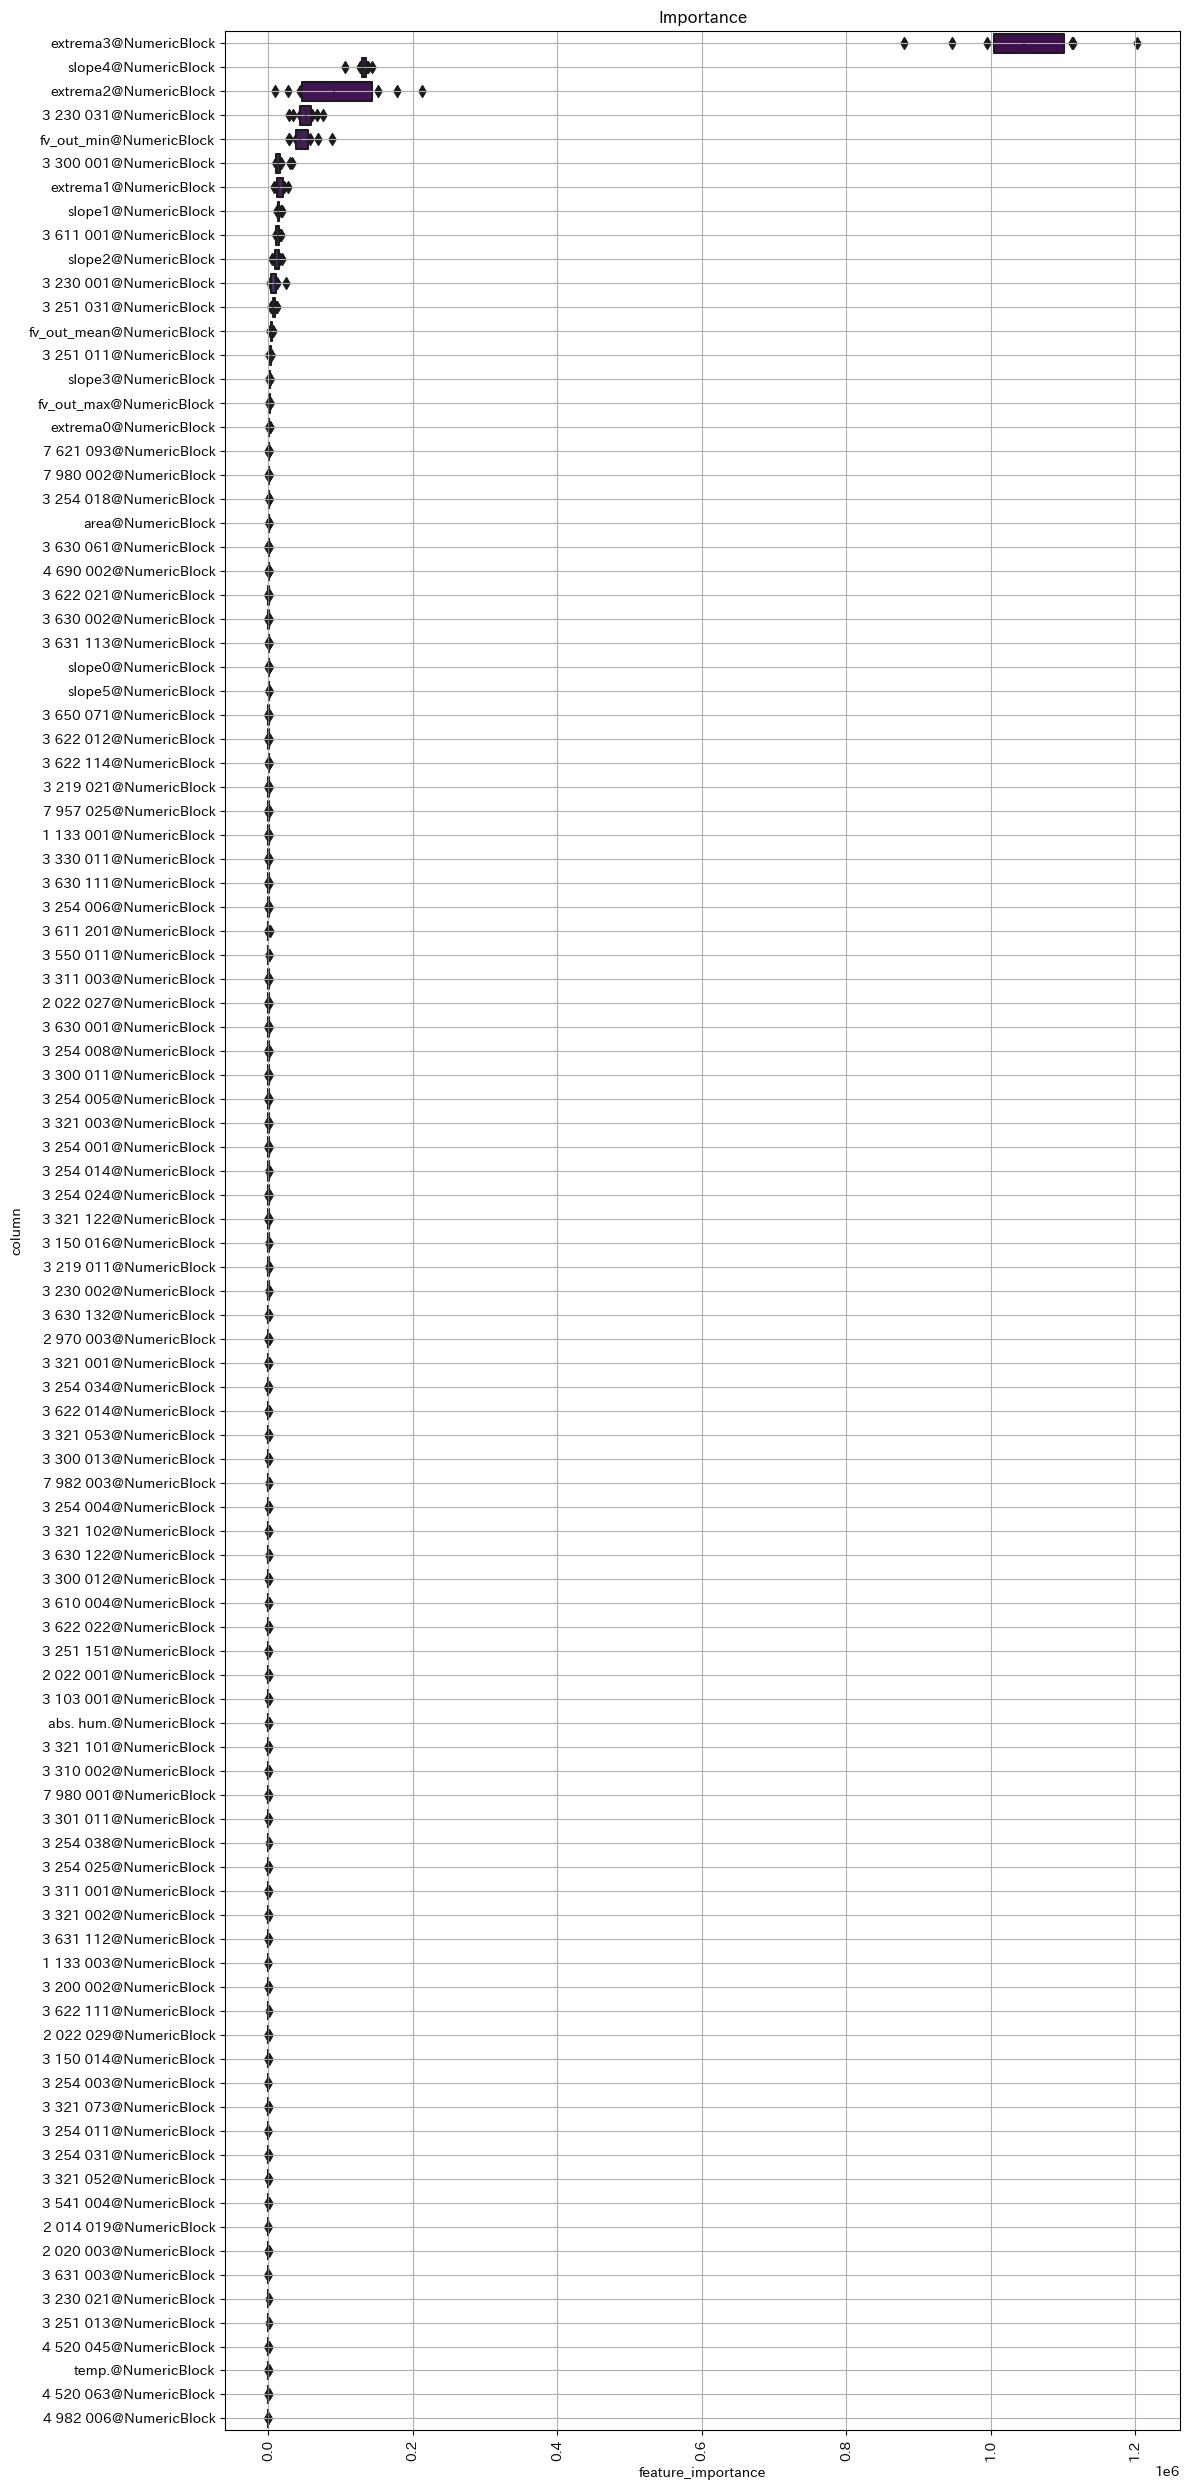

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:100]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df


fig, ax, fi_df = visualize_importance(models, train_feat_df)

# test dataで推論
trainデータを学習に回して、 testデータに対して推論

In [ ]:
# trainで作成した情報でtestの特徴量を生成
test_feat_df = run_blocks(input_df = test_df, blocks=feature_blocks, y=None, test=True)

In [ ]:
# paramsはtrain時のものを使うが、iterationの数はデータ数に必要に応じて修正

max_iteration = np.max(models_best_iterations)

# CVのときと比べて増えたデータ数の割合だけ ざっくりだけどiterationの回数も増やすことにする(データ量20%Up → iteration 20%Up)
increase_ratio = (CFG.n_fold / (CFG.n_fold -1))
n_estimators = int(max_iteration * increase_ratio)

test_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': n_estimators,
    'boosting_type': 'gbdt',
    'learning_rate' : lr,
    'max_depth' : max_depth,
    'importance_type': 'gain',
    'seed' : 0,
    }


In [ ]:
max_iteration, n_estimators

(1052, 1315)

In [ ]:
test_model = lgbm.LGBMRegressor(**test_params)
test_model.fit(
    train_feat_df.values,
    y_train,
)

LGBMRegressor(importance_type='gain', learning_rate=0.05, max_depth=1,
              metric='rmse', n_estimators=1315, objective='regression', seed=0)

test data RMSE 0.26327099916968116
test data R2 score 0.9925179329107126


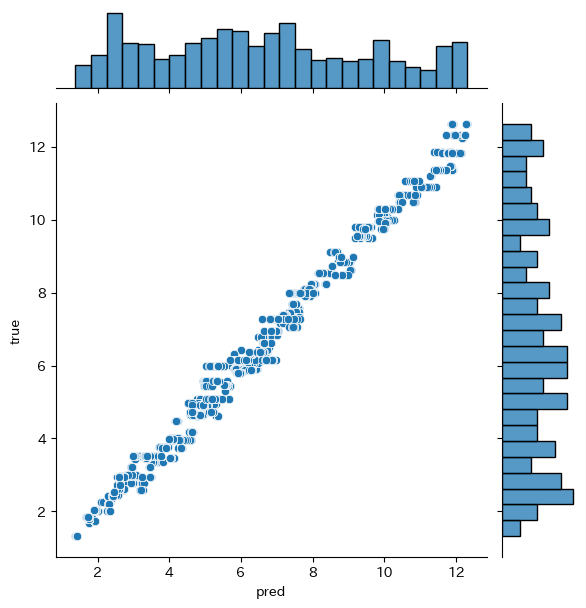

In [ ]:
pred = test_model.predict(test_feat_df)
y_true = test_df[y_col]

print(f'test data RMSE {np.sqrt(mean_squared_error(y_true, pred))}')
print(f'test data R2 score {r2_score(y_true, pred)}')
sns.jointplot(x=pred, y=y_true)
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

In [ ]:
# seedを変えたモデルでアンサンブルして、estimatorsが過剰になったとしても悪化を最小限にしたい 参考https://note.com/currypurin/n/n7bd3153a7238
test_params['seed'] = 42
test_model2 = lgbm.LGBMRegressor(**test_params)
test_model2.fit(
    train_feat_df.values,
    y_train,
)

LGBMRegressor(importance_type='gain', learning_rate=0.05, max_depth=1,
              metric='rmse', n_estimators=1315, objective='regression',
              seed=42)

In [ ]:
pred = test_model2.predict(test_feat_df)
y_true = test_df[y_col]

print(f'test data RMSE {np.sqrt(mean_squared_error(y_true, pred))}')
print(f'test data R2 score {r2_score(y_true, pred)}')

test data RMSE 0.26327099916968116
test data R2 score 0.9925179329107126


結果変わらず。  データが少ない場合はつくられる木も同じになりやすいらしい。 今回の場合は失敗

## CVの5_FOLD×3_repeats のモデルでアンサンブルした場合はどうか

test data RMSE 0.2830756842163714
test data R2 score 0.9913499088047459


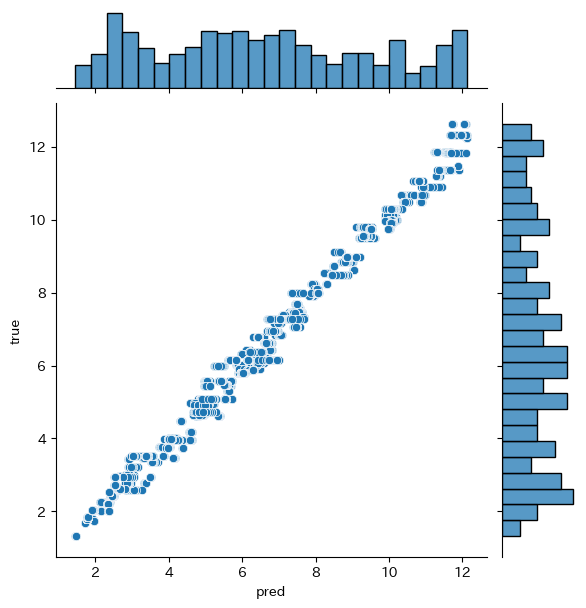

In [ ]:
preds = []
for model in models:
    preds.append(model.predict(test_feat_df))

pred_ensamble = np.mean(preds, axis=0)

print(f'test data RMSE {np.sqrt(mean_squared_error(y_true, pred_ensamble))}')
print(f'test data R2 score {r2_score(y_true, pred_ensamble)}')
sns.jointplot(x=pred_ensamble, y=y_true)
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

ちょっぴりスコア高い

# 結果の分析

## 外れているデータはどういったものか?

<AxesSubplot:xlabel='tc_mean', ylabel='Count'>

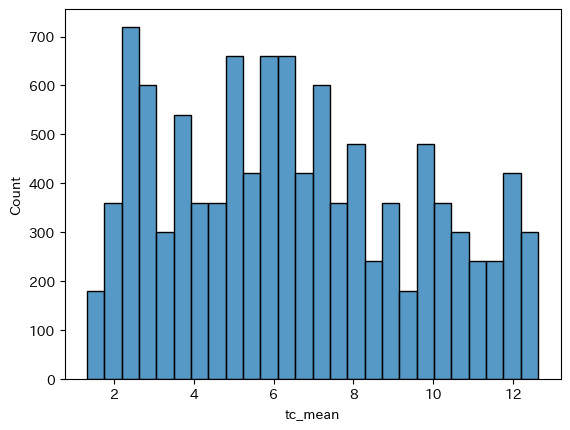

In [ ]:
sns.histplot(test_df['tc_mean'])

In [ ]:
test_df['pred'] = pred
test_df['diff_true_pred'] = test_df['tc_mean'] - test_df['pred']
test_df['abs_diff_true_pred'] = abs(test_df['diff_true_pred'])
test_df.sort_values('abs_diff_true_pred', ascending=False, inplace=True)


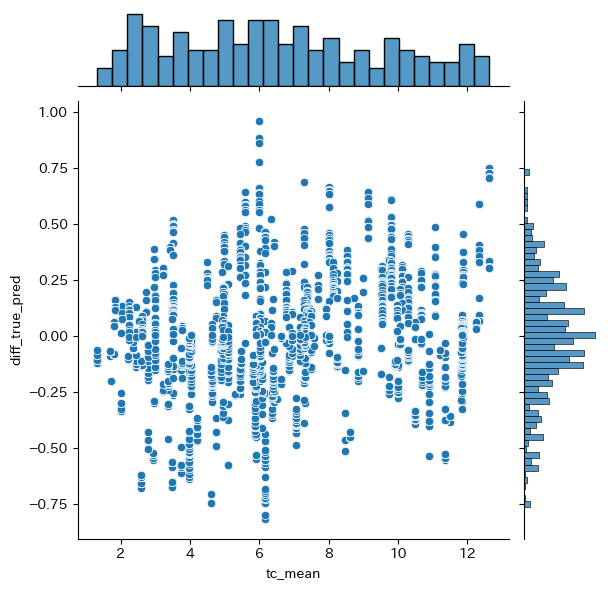

In [ ]:
sns.jointplot(x='tc_mean', y='diff_true_pred', data=test_df)

## 特徴量とdiffをみる

In [ ]:
fi_df_top5 = fi_df.groupby(by='column', as_index=False).median().sort_values(by='feature_importance', ascending=False).head()
fi_df_top5
# fi_df.sort_values(by='feature_importance', ascending=False)

,column,feature_importance,fold
783,extrema3@NumericBlock,1.046080e+06,5.5
794,slope4@NumericBlock,1.306715e+05,5.5
782,extrema2@NumericBlock,9.087083e+04,5.5
150,3 230 031@NumericBlock,5.150987e+04,5.5
786,fv_out_min@NumericBlock,4.358392e+04,5.5


In [ ]:
test_df

,tc_mean,page,speed,scr_rpm,fv_out_mean,fv_out_max,fv_out_min,slope0,slope1,slope2,slope3,slope4,slope5,extrema0,extrema1,extrema2,extrema3,area,temp.,rel. hum.,abs. hum.,1 133 001,1 133 002,1 133 003,1 133 004,...,9 111 001,9 111 010,9 111 011,9 111 012,9 111 013,9 111 014,9 111 015,9 111 016,9 111 017,9 111 018,9 111 019,9 111 020,9 111 021,9 111 022,9 111 023,9 111 024,9 111 025,9 111 026,9 510 001,9 510 003,9 997 001,waveform_no,pred,diff_true_pred,abs_diff_true_pred
20836,6.000,50.0,std,612.26,0.813373,2.915707,0.372795,-0.133181,-0.047846,-0.031757,0.001703,-0.002312,-0.006326,2.915707,0.518453,0.571244,0.375127,40.657154,334.0,524.0,1961.0,101.1,107.4,100.9,101.6,...,1.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,11.0,347,5.036289,0.963711,0.963711
20855,6.000,50.0,std,612.26,0.803289,2.919545,0.370761,-0.133558,-0.048262,-0.031807,0.001264,-0.002266,-0.005796,2.919545,0.515501,0.554685,0.375011,39.855021,334.0,524.0,1961.0,101.1,107.4,100.9,101.6,...,1.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,11.0,347,5.113951,0.886049,0.886049
20858,6.000,50.0,std,612.26,0.805138,2.895784,0.367404,-0.131716,-0.047487,-0.031383,0.001420,-0.002254,-0.005929,2.884175,0.513279,0.557304,0.373511,40.375358,334.0,524.0,1961.0,101.1,107.4,100.9,101.6,...,1.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,11.0,347,5.137868,0.862132,0.862132
20827,6.000,50.0,std,612.26,0.808504,2.899016,0.370932,-0.131745,-0.047372,-0.031406,0.001618,-0.002275,-0.006169,2.886347,0.514933,0.565104,0.373853,40.360276,334.0,524.0,1961.0,101.1,107.4,100.9,101.6,...,1.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,11.0,347,5.137868,0.862132,0.862132
5616,6.152,25.0,std,612.26,1.262178,3.085220,0.943639,-0.115539,-0.040581,-0.026152,0.002943,-0.000201,-0.003346,3.043886,0.964183,1.055406,0.951691,29.095908,111.0,104.0,150.0,99.9,106.6,99.9,102.0,...,1.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,11.0,93,6.969080,-0.817080,0.817080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31999,6.631,100.0,mid,258.30,0.733079,1.094507,0.575965,-0.012164,-0.003150,-0.002618,0.001241,-0.000351,-0.001866,1.094507,0.632281,0.729111,0.576093,35.933688,260.0,239.0,610.0,99.7,107.0,96.8,101.5,...,0.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,12.0,533,6.629760,0.001240,0.001240
32001,6.631,100.0,mid,258.30,0.736640,1.095837,0.579703,-0.012072,-0.003096,-0.002602,0.001277,-0.000352,-0.001902,1.095756,0.637009,0.736612,0.580645,35.893267,260.0,239.0,610.0,99.7,107.0,96.8,101.5,...,0.0,3.298028e+09,858958841.0,2.661743e+09,870820339.0,129822247.0,1.694735e+09,190003633.0,201344607.0,4.223416e+09,1.312544e+09,1.355676e+09,4.130149e+09,661362931.0,1.275327e+09,3.189126e+09,3.321058e+09,1.0,3.0,3.0,12.0,533,6.629760,0.001240,0.001240
32002,6.631,100.0,mid,258.30,0.735525,1.098324,0.577310,-0.012262,-0.003168,-0.002627,0.001262,-0

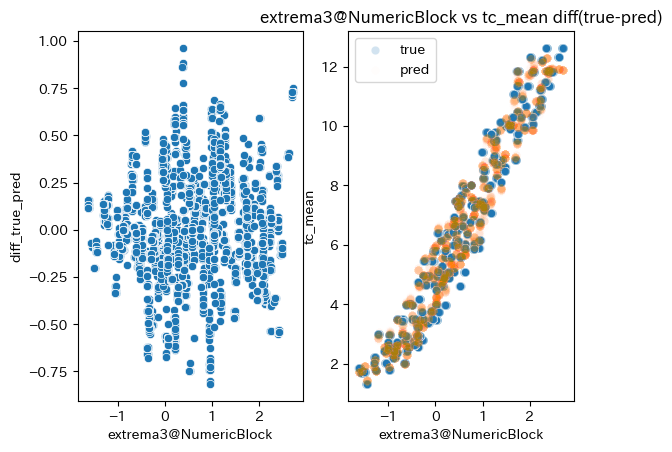

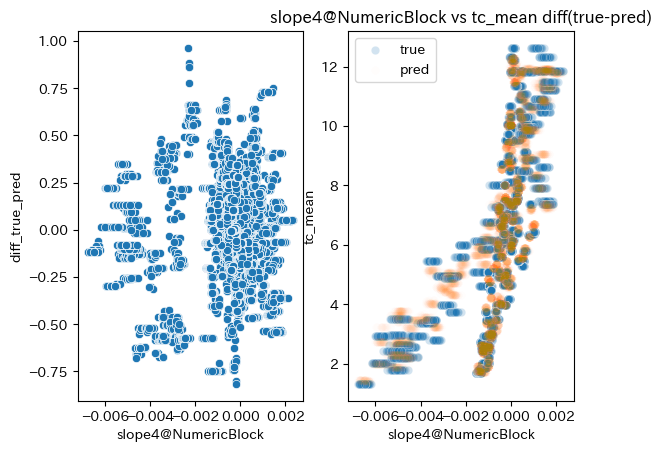

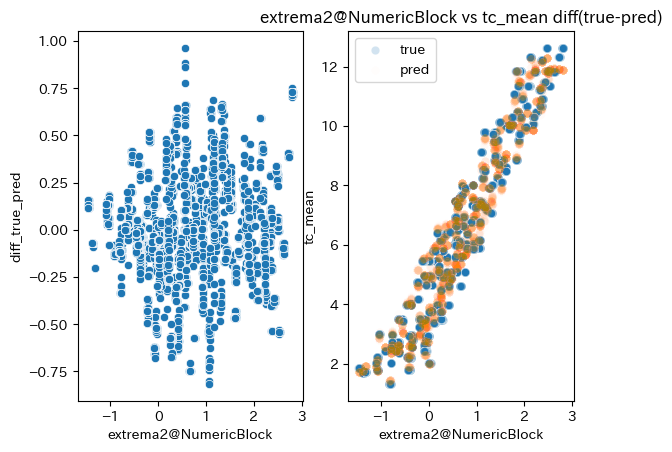

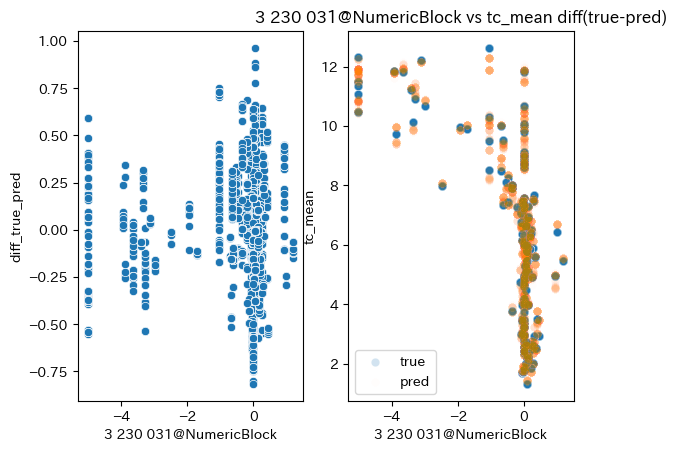

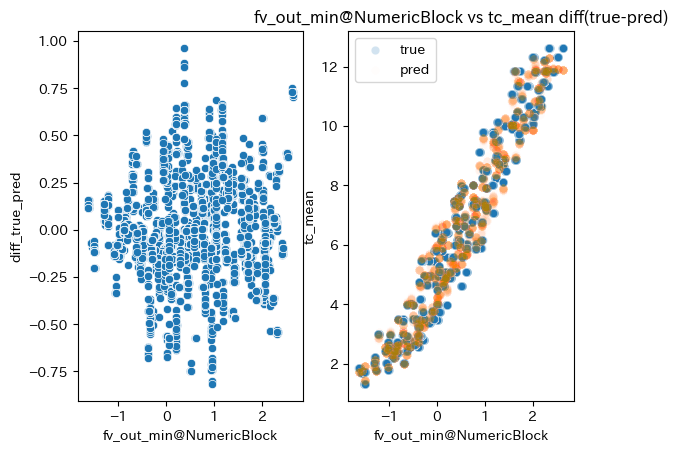

In [ ]:
for feature in fi_df_top5['column']:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sns.scatterplot(x=test_feat_df[feature], y=test_df['diff_true_pred'], ax=axes[0])
    sns.scatterplot(x=test_feat_df[feature], y=test_df['tc_mean'], ax=axes[1], label='true', alpha=0.2)
    sns.scatterplot(x=test_feat_df[feature], y=test_df['pred'], ax=axes[1], label='pred', alpha=0.01)
    plt.legend()
    plt.title(f'{feature} vs tc_mean diff(true-pred)')
    plt.show()

オレンジ(予測値)がいっぱい重なって見える。  
木の出力値のバリエーションがすくないということ? = データ量が少ない?

In [ ]:
len(np.array(pred)),  len(np.unique(np.array(pred)))

(10800, 1138)

In [ ]:
len(test_df), len(test_df['tc_mean'].unique()), 

(10800, 120)

In [ ]:
len(train_df), len(train_df['tc_mean'].unique()), 

(21600, 172)